In [1]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

In [2]:
def init_state_social_distancing_actions(path):
  df_master = pd.DataFrame()
  flag = False
  files_in_folder = glob.glob(path)
  for filename in files_in_folder:    
    zip_file = ZipFile(filename)
    for text_file in zip_file.infolist():
      # if not text_file.filename.startswith('__MACOSX/'):
      if text_file.filename.endswith('.csv'):
        date = re.search('\d*-\d*-\d*', text_file.filename)[0]
        if date == "20201-06-01":
          date = "2021-06-01"
        date_time_value = pd.to_datetime(date)
        df = pd.read_csv(zip_file.open(text_file.filename), sep=",", header=0)
        df["Date"] = date_time_value
        df.rename(columns = {'Unnamed: 0':'State'}, inplace = True)
        df.drop((df[df.State.isin(["United States"])].index) | (df[df.State.isnull()].index), inplace=True)
      if not flag:
        df_master = df
        flag = True
      else:
        df_master = pd.concat([df_master, df])
  df_master.set_index(["Date", "State"], inplace=True)
  df_master.sort_index(inplace=True)
  return df_master

state_social_distancing_actions = init_state_social_distancing_actions(r'**csv_files/state_social_distancing_actions.zip')

In [3]:
def clean_state_social_distancing_actions(df):
  df = df.drop(columns=["Primary Election Postponement"])
  return df

cleaned_state_social_distancing_actions = clean_state_social_distancing_actions(state_social_distancing_actions)
cleaned_state_social_distancing_actions

State Is Easing Social Distancing Measures  \
Date       State                                                      
2020-06-04 Alabama                                              Yes   
           Alaska                                               Yes   
           Arizona                                              Yes   
           Arkansas                                             Yes   
           California                                           Yes   
...                                                             ...   
2021-11-09 Virginia                                             NaN   
           Washington                                           NaN   
           West Virginia                                        NaN   
           Wisconsin                                            NaN   
           Wyoming                                              NaN   

                         Stay at Home Order  \
Date       State                              
2020-06-04 Alabama                   Lifted   
           Alaska                    Lifted   
           Arizona                   Lifted   
           Arkansas                       -   
           California             Statewide   
...                                     ...   
2021-11-09 Virginia                     NaN   
           Washington                   NaN   
           West Virginia                NaN   
           Wisconsin                    NaN   
           Wyoming                      NaN   

                         Mandatory Quarantine for Travelers  \
Date       State                                              
2020-06-04 Alabama                                        -   
           Alaska                             All Travelers   
           Arizona                                   Lifted   
           Arkansas                     From Certain States   
           California                                     -   
...                                                     ...   
2021-11-09 Virginia                                     NaN   
           Washington                                   NaN   
           West Virginia                                NaN   
           Wisconsin                                    NaN   
           Wyoming                                      NaN   

                                            Non-Essential Business Closures  \
Date       State                                                              
2020-06-04 Alabama        All Non-Essential Businesses Permitted to Reop...   
           Alaska          All Non-Essential Businesses Permitted to Reopen   
           Arizona        All Non-Essential Businesses Permitted to Reop...   
           Arkansas                                                       -   
           California     Some Non-Essential Businesses Permitted to Reo...   
...                                                                     ...   
2021-11-09 Virginia                                                     NaN   
           Washington                                                   NaN   
           West Virginia                                                NaN   
           Wisconsin                                                    NaN   
           Wyoming                                                      NaN   

                               Large Gatherings Ban  \
Date       State                                      
2020-06-04 Alabama                           Lifted   
           Alaska                            Lifted   
           Arizona                           Lifted   
           Arkansas           >10 People Prohibited   
           California     All Gatherings Prohibited   
...                                             ...   
2021-11-09 Virginia                             NaN   
           Washington                           NaN   
           West Virginia                        NaN   
           Wisconsin                

Clean up the dataframe to remove unused columns and solve for Nan fields. 
- Have to manually insert face mask requirements for recent months based on: https://statepolicies.com/data/graphs/face-masks/
- Face mask mandate was reintroduced from Dec 15, 2021 -> Feb 15, 2022

Other changes
- Manually inserted "No Limit" after 2021-08-15 because missing data

In [4]:
california_data = cleaned_state_social_distancing_actions[cleaned_state_social_distancing_actions.index.get_level_values('State').isin(['California'])]
california_data.reset_index("State", inplace=True)
california_data = california_data[~california_data.index.duplicated(keep='first')]
# Fill inn missing dates with rows equal the previous date with data
days_idx = pd.date_range(start=california_data.index[0], end="2022-04-18", freq="D")
california_data = california_data.reindex(days_idx, method="pad")
# Update facemask data
california_data.loc[: "2020-06-17", "Face Covering Requirement"] = 0 # No
california_data.loc["2020-06-18" : "2021-06-14", "Face Covering Requirement"] = 1 # Yes
california_data.loc["2021-06-15" : "2021-12-14", "Face Covering Requirement"] = 0
california_data.loc["2021-12-15" : "2022-02-14", "Face Covering Requirement"] = 1
california_data.loc["2022-02-15" : , "Face Covering Requirement"] = 0
# Manually insert gathering limit for missing values
california_data.loc["2021-08-16 ":, "Large Gatherings Ban"] = "No Limit"
# Transform Large Gatherings Ban to a sevearity of the rules (1: no restrictions, 5: All gatherings prohibited)
california_data["Large Gatherings Ban"].replace({'All Gatherings Prohibited': 5, '>50 Prohibited': 4, 'Expanded Limit to 25 or Fewer': 3, '>25 Prohibited': 3, '>10 Prohibited': 2, 'No Limit': 1}, inplace=True)


selected_ca_restrictions = california_data[["Face Covering Requirement", "Large Gatherings Ban"]]
selected_ca_restrictions

,Face Covering Requirement,Large Gatherings Ban
2020-06-04,0,5
2020-06-05,0,5
2020-06-06,0,5
2020-06-07,0,5
2020-06-08,0,5
...,...,...
2022-04-14,0,1
2022-04-15,0,1
2022-04-16,0,1
2022-04-17,0,1


Import the vaccination data

In [5]:
def init_vaccination_df_from_zip(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

vaccination_df = init_vaccination_df_from_zip(r'**csv_files/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv.zip', ["Date"])
vaccination_df = vaccination_df[vaccination_df["Location"] == "CA"]
vaccination_df.index = pd.to_datetime(vaccination_df.index)
vaccination_df.sort_index(inplace=True)

Add ekstra columns to have the same time-range as the other datasets
- Insert 0 as the number of vaccinated since no-one was vaccinated at the first date of the current df

In [6]:
days_idx = pd.date_range(start="2020-06-04", end="2020-12-13", freq="D")
days_with_missing_data = vaccination_df.reindex(days_idx, fill_value=0)
days_with_missing_data["Location"] = "CA"
days_with_missing_data.index.names = ['Date']
vaccination_df = days_with_missing_data.append(vaccination_df)
vaccination_df_administered = pd.DataFrame(vaccination_df["Administered"])
vaccination_df_administered.rename(columns={"Administered": "Total Vaccines Administered"}, inplace=True)
vaccination_df_administered

,Total Vaccines Administered
Date,
2020-06-04,0
2020-06-05,0
2020-06-06,0
2020-06-07,0
2020-06-08,0
...,...
2022-04-16,74123212
2022-04-17,74232595
2022-04-18,74270938


Import daily covid deaths

In [7]:
def init_daily_reports(path):
  df_master = pd.DataFrame()
  flag = False
  files_in_folder = glob.glob(path)
  for filename in files_in_folder:    
    zip_file = ZipFile(filename)
    for text_file in zip_file.infolist():
      # if not text_file.filename.startswith('__MACOSX/'):
      if text_file.filename.endswith('.csv'):
        date = re.search('\d*-\d*-\d*', text_file.filename)[0]
        date_time_value = pd.to_datetime(date)
        df = pd.read_csv(zip_file.open(text_file.filename), sep=",", header=0)
        df["Date"] = date_time_value
        df.rename(columns = {'Province_State':'State'}, inplace = True)
        df.drop((df[df.State.isin(["United States"])].index) | (df[df.State.isnull()].index), inplace=True)
      if not flag:
        df_master = df
        flag = True
      else:
        df_master = pd.concat([df_master, df])
  df_master.set_index(["Date", "State"], inplace=True)
  df_master.sort_index(inplace=True)
  return df_master

covid_daily_reports = init_daily_reports(r'**csv_files/csse_covid_19_daily_reports_us.zip')

covid_daily_reports = covid_daily_reports.reset_index()

states = ['California']
covid_daily_reports = covid_daily_reports[covid_daily_reports["State"].isin(states) == True]
covid_daily_reports.set_index(["Date"], inplace=True)

In [8]:
deaths_data = pd.DataFrame(covid_daily_reports["Deaths"])
deaths_data["Daily Deaths"] = deaths_data.diff(periods=1)
deaths_data = deaths_data[~deaths_data.index.duplicated(keep='first')]
deaths_data.drop(["Deaths"], axis=1, inplace=True)
# For all the values where the death count is less than 0 we set the value to be equal 0
deaths_data[deaths_data["Daily Deaths"] < 0] = 0

Import infection rate data

In [9]:
def init_infection_dataframe_from_zip(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

infected_df = init_infection_dataframe_from_zip(r'**csv_files/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv.zip', ["submission_date", "state"])
infected_df.index = infected_df.index.set_levels([pd.to_datetime(infected_df.index.levels[0]), infected_df.index.levels[1]])
infected_df_CA = infected_df[infected_df.index.get_level_values('state').isin(['CA'])]
infected_df_CA = infected_df_CA.reset_index()
infected_df_CA.set_index(["submission_date"], inplace=True)
infected_df_CA = infected_df_CA[["tot_cases"]].sort_index()

Make sure all dataframes share the same date-time range
- selected_ca_restrictions: 2020-06-04 - 2022-04-18	
- vaccination_df: 2020-06-04 - 2022-04-20
- Death data: 2020-04-12 - 2022-03-28

In [10]:
merged_data = pd.concat([selected_ca_restrictions["2020-06-04" : "2022-03-28"], vaccination_df_administered["2020-06-04" : "2022-03-28"], infected_df_CA["2020-06-04" : "2022-03-28"], deaths_data["2020-06-04" : ]], axis=1)
merged_data

,Face Covering Requirement,Large Gatherings Ban,Total Vaccines Administered,tot_cases,Daily Deaths
2020-06-04,0,5,0,119807,79.0
2020-06-05,0,5,0,122901,69.0
2020-06-06,0,5,0,126016,71.0
2020-06-07,0,5,0,128812,26.0
2020-06-08,0,5,0,131319,28.0
...,...,...,...,...,...
2022-03-24,0,1,72454498,9071134,125.0
2022-03-25,0,1,72488669,9074163,103.0
2022-03-26,0,1,72519770,9074163,18.0
2022-03-27,0,1,72551454,9074163,0.0


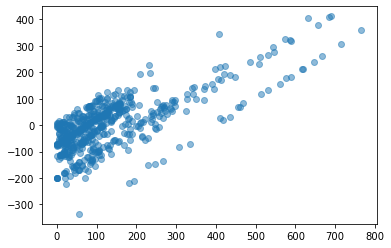

In [11]:
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

train, val = train_test_split(merged_data, test_size = 0.1, random_state = 42)
Y_train = train["Daily Deaths"]
X_train = train.drop(["Daily Deaths"], axis=1)

linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(X_train, Y_train)
y_prediction = linear_model.predict(X_train)
rmse = mean_squared_error(Y_train, y_prediction, squared=False)
rmse
plt.scatter(Y_train, Y_train-y_prediction, alpha=0.5);


#clf = svm.SVC(kernel='linear', C=1, random_state=42)
#scores = cross_val_score(clf, X_train, Y_train, cv=5)
#scores

In [12]:
# Followed example: https://towardsdatascience.com/improve-linear-regression-for-time-series-forecasting-e36f3c3e3534
# https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/ModelTrees_TimeSeries/ModelTrees_TimeSeries.ipynb
# https://github.com/cerlymarco/MEDIUM_NoteBook

X_train_, X_test_, y_train_, y_test_ = train_test_split(
    merged_data.drop('Daily Deaths', axis=1), 
    merged_data['Daily Deaths'], 
    test_size=0.3, shuffle=False)

X_train_.shape, X_test_.shape

((464, 4), (199, 4))

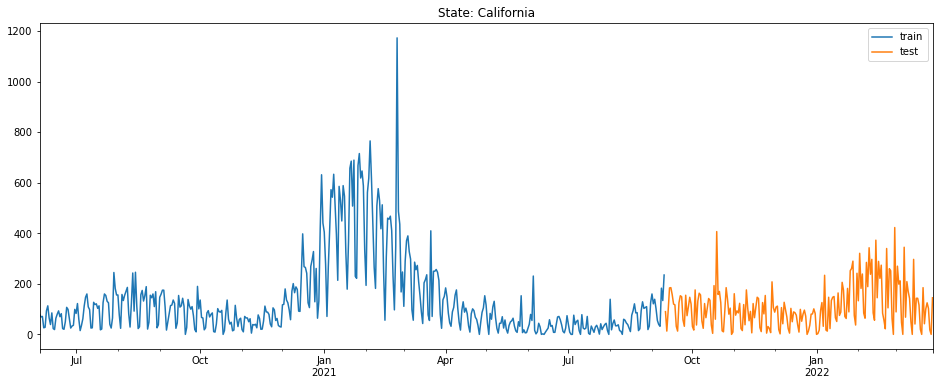

In [13]:
### PLOT STORE DATA ###

y_train_.plot(label='train', figsize=(16,6))
y_test_.plot(label='test')
plt.title("State: {}".format("California")); plt.legend();

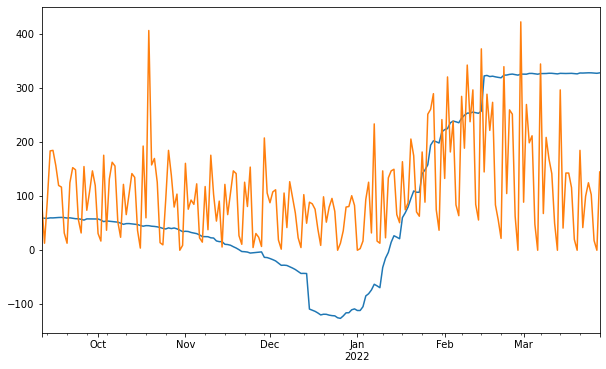

In [14]:
#model = lm.LinearRegression(fit_intercept=True)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train_, y_train_)

pred_lr = pd.Series(model.predict(X_test_), index = y_test_.index)
pred_lr.plot(label='linear_regression')
y_test_.plot(label='true', figsize=(10,6));


In [15]:
# Find number of days with deaths equal to 0
#zero_death_days = merged_data.loc[merged_data["Daily Deaths"] == 0]
#zero_death_days.reset_index(inplace=True)
#zero_death_days['weekday'] = zero_death_days['index'].dt.dayofweek # Monday=0, Sunday=6
#zero_death_days

## After not setting days with negative numbers equal to zero then there are 13 days equal to 0
## 6 of them is a sunday, 6 is a saturday, and 1 is a monday

In [16]:
!pip install pystan==2.19.1.1
!pip install fbprophet
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


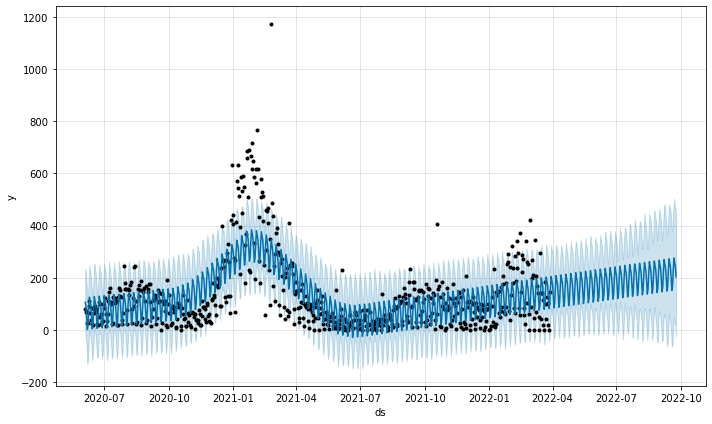

In [17]:
from fbprophet import Prophet
model = Prophet()

hans_data = merged_data.copy().reset_index()
hans_data = hans_data.rename(columns={"index": "ds", "Daily Deaths": "y"})
model.fit(hans_data)
future = model.make_future_dataframe(periods=180)
future.tail()
forecast = model.predict(future)

fig1 = model.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


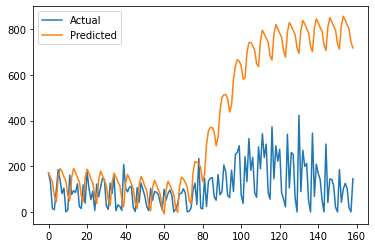

In [18]:
from fbprophet import Prophet
m = Prophet()
m.add_regressor('Face Covering Requirement')
m.add_regressor('Large Gatherings Ban')
m.add_regressor('Total Vaccines Administered')
m.add_regressor('tot_cases')

df_train = hans_data.loc[hans_data["ds"]<"2021-10-21"]
df_test  = hans_data.loc[hans_data["ds"]>="2021-10-21"]

m.fit(df_train)
forecast = m.predict(df_test.drop(columns="y"))

y_true = df_test['y'].values
y_pred = forecast['yhat'].values
#mae = mean_absolute_error(y_true, y_pred)
#print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()